<a href="https://colab.research.google.com/github/ayportella/projects_machine_learning/blob/main/01_projeto_extra_machine_learning_geochemistry_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto de Machine Learning**

[Andressa Yumi Portella](https://www.linkedin.com/in/andressa-yumi-portella/)<br>
Maio de 2023

# **1. Coleta de Dados**

O dataset desse projeto é o [Regional Geochemical Survey Dataset](https://open.canada.ca/data/en/dataset/49a73c36-4a25-4be5-b6d1-abd020fb031a), um programa conduzido pelo Canadá desde 1976 para auxiliar a exploração e o desenvolvimento de recursos minerais no país. Foi escolhido o dataset geoquímico de dados de sedimentos de corrente. <br>
<br>
Sedimentos de corrente fazem parte do principal método de pesquisas regionais, indicando a litologia da área de drenagem e, consequentemente, o depósito mineral que ocorre a montante do rio.<br>
<br>
A ideia desse projeto é **prever as unidades geológicas** (Formação ou Grupo, classificação de rochas baseadas em suas características e idades, explicando de uma maneira simplificada) **a partir de concentração de alguns elementos químicos e dados de posicionamento** (latitude e longitude).<br>
<br>
Foram escolhidos os elementos químicos Chumbo (Pb), Zinco (Zn) e Cobre (Cu) baseados em pesquisa sobre a geologia do local da região de Quest, um platô em Prince George, Canadá. Trata-se de uma região com mineralizações de Cu-Au porfirítico, o que motivou a escolha desses elementos para a predição da estratigrafia.<br>
<br>
Teria sido importante usar o elemento químico Ouro (Au) como parâmetro no modelo, mas as concentrações desse elemento não estavam disponíveis no dataset para a região escolhida de Quest.

Houve a parte de limpeza dos dados em um editor de planilhas, com a filtragem dos dados da área de Quest, a região dentre todas as outras que tem o maior número de dados.
<br>

Quest fica no platô central de Brithish Columbia, perto da cidade de Prince George. A geologia da área é caracterizada por sedimentos de idade variando entre o Cretáceo ao Oligoceno da Bacia de Nechako, que é rodeada por montanhas costeiras a oeste e a leste.
<br>
Houve posterior remoção de linhas nas quais as unidades geológicas tinham menos de 30 ocorrências no dataset, sendo as escolhidas as seguintes (Kushnir et al. 2012):
<br>

LTQch : Chilcotin Group Volcanic Rocks (Neógeno)<br>
uTrJNc: Triassic to Jurassic Nicola group<br>
TrJTK: Triassic to Jurassic Takla Group<br>
MTrCc: Mississipian to Triassic Cacho Creek Group<br>
CPSm: Carboniferous to Permian Slide Mountain Group<br>
KTpg: Cretaceous to Paleogene intrusive and high-grade metamorphic rocks<br>

Ou seja, as 5 primeiras litologias acima correspondem a rochas estratificadas, e a última, a intrusões de alto grau metamórfico.



Mapa Geológico Simplificado de Nechako Basin e Regiões Adjacentes<br>
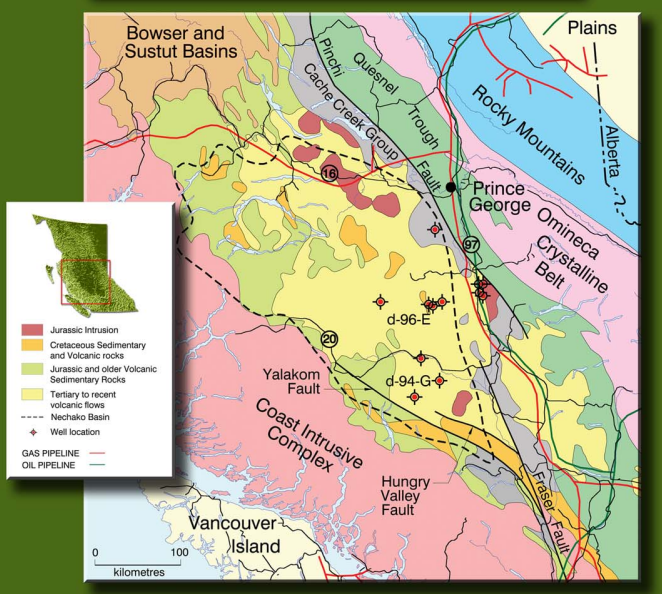

Seção Geológica simplificada da porção central de Nechako Basin<br>
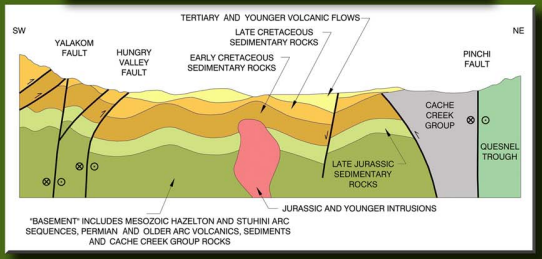

In [22]:
#importando bibliotecas
import sklearn
import sklearn.metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
#lendo o arquivo csv
quest = pd.read_csv('questdata2.csv')

In [24]:
#vendo as 5 primeiras linhas do dataset
quest.head(5)

,LAT,LONG,STRAT,Cu_ICP_PPM,Pb_ICP_PPM,Zn_ICP_PPM
0,53.61138,-122.97780,LTQCh,48.56,5.77,81.7
1,53.62691,-122.96569,LTQCh,27.40,4.51,21.5
2,53.65023,-122.98068,LTQCh,43.50,5.51,111.6
3,53.66609,-123.02010,LTQCh,56.89,7.99,86.8
4,53.63407,-122.99388,LTQCh,53.25,9.17,99.4


 **1.1. Análise Exploratória**

Os gráficos abaixo ajudarão a entender melhor a relação entre os atributos escolhidos e a variável resposta (estratigrafia) da base de dados.

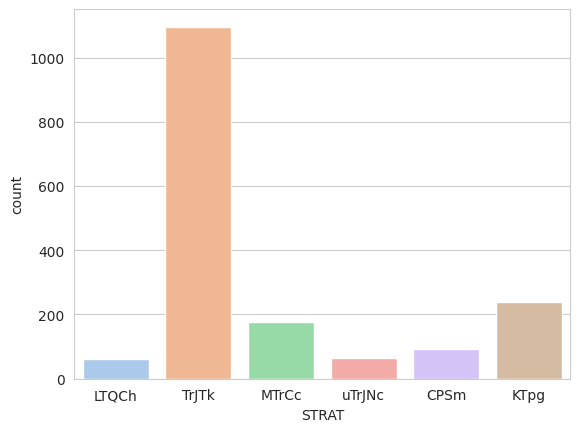

In [25]:
with sns.axes_style('whitegrid'):
  grafico = sns.countplot(data=quest, x='STRAT', palette="pastel")

In [26]:
data = quest.groupby(['STRAT']).count()
data

,LAT,LONG,Cu_ICP_PPM,Pb_ICP_PPM,Zn_ICP_PPM
STRAT,,,,,
CPSm,93,93,93,92,93
KTpg,240,240,240,238,240
LTQCh,60,60,60,60,60
MTrCc,177,177,177,166,177
TrJTk,1096,1096,1096,1055,1096
uTrJNc,63,63,63,58,63


Percebe-se que pode haver um viés de amostragem, uma vez que TrJTk está mais presente que os outros dados, numa ordem de grandeza muito maior. Porém isso é muito comum na geologia, uma vez que os pontos de amostragem dependem da coleta, grau de intemperismo, facilidade de acesso aos pontos de amostra, classificação do intérprete, entre outros fatores.
<br>
<br>



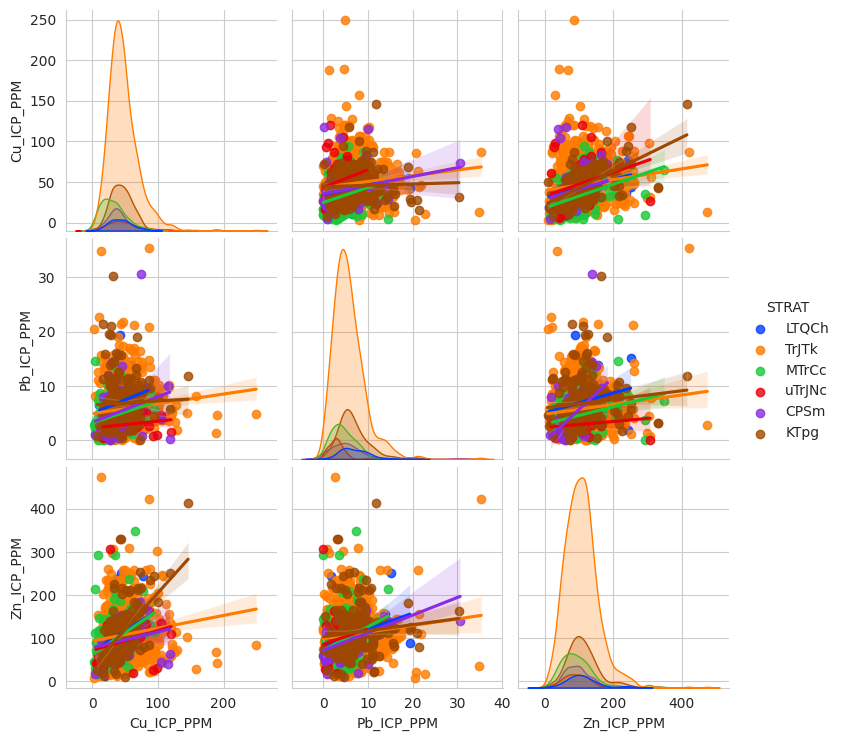

In [27]:
with sns.axes_style('whitegrid'):
  grafico = sns.pairplot(data=quest.drop(['LAT','LONG'], axis=1), hue="STRAT", palette="bright", kind='reg', diag_kind='kde')


**Comentário:**

Apesar do viés de amostragem de TrJNc roubar a cena nesses gráficos pela sua grande quantidade de amostras, os gráficos de dispersão mostram que há correlação positiva entre as diferentes concentrações de elementos químicos.

**1.2. Data Wrangling**

Verificando se a base de dados tem valores faltantes.

In [29]:
quest.isnull().sum()

LAT            0
LONG           0
STRAT          0
Cu_ICP_PPM     0
Pb_ICP_PPM    60
Zn_ICP_PPM     0
dtype: int64

In [30]:
quest.describe()

,LAT,LONG,Cu_ICP_PPM,Pb_ICP_PPM,Zn_ICP_PPM
count,1729.000000,1729.000000,1729.000000,1669.000000,1729.000000
mean,54.378633,-123.291742,44.546524,5.697627,104.986698
std,0.476532,0.491792,22.084590,3.667579,48.665024
min,53.195060,-124.992740,2.600000,0.010000,8.000000
25%,54.073600,-123.621480,30.410000,3.300000,72.100000
50%,54.428640,-123.264910,41.030000,5.110000,99.800000
75%,54.736290,-123.026130,54.710000,7.380000,128.000000
max,55.247780,-121.916790,249.600000,35.340000,474.100000


Ainda que apenas 3% dos dados estejam faltantes na coluna de concentração de Chumbo, iremos imputar os valores faltantes. Porém isso será feito após o split entre treino e teste!

In [ ]:
#antes eu substitui os valores faltantes pela média do elemento Pb, porém não farei isso dessa vez
#quest_2 = quest.fillna(value=quest["Pb_ICP_PPM"].mean())

In [ ]:
#quest_2.isnull().sum()

**1.3. Treino/Teste**

Separando a base de dados em treino e teste e utilizando uma proporção de 2/3 para treino e 1/3 para testes.



In [31]:
quest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAT         1729 non-null   float64
 1   LONG        1729 non-null   float64
 2   STRAT       1729 non-null   object 
 3   Cu_ICP_PPM  1729 non-null   float64
 4   Pb_ICP_PPM  1669 non-null   float64
 5   Zn_ICP_PPM  1729 non-null   float64
dtypes: float64(5), object(1)
memory usage: 81.2+ KB


In [32]:
quest.describe().T

,count,mean,std,min,25%,50%,75%,max
LAT,1729.0,54.378633,0.476532,53.19506,54.07360,54.42864,54.73629,55.24778
LONG,1729.0,-123.291742,0.491792,-124.99274,-123.62148,-123.26491,-123.02613,-121.91679
Cu_ICP_PPM,1729.0,44.546524,22.084590,2.60000,30.41000,41.03000,54.71000,249.60000
Pb_ICP_PPM,1669.0,5.697627,3.667579,0.01000,3.30000,5.11000,7.38000,35.34000
Zn_ICP_PPM,1729.0,104.986698,48.665024,8.00000,72.10000,99.80000,128.00000,474.10000


In [33]:
from sklearn.model_selection import train_test_split


In [34]:
X = quest[["LAT","LONG","Cu_ICP_PPM","Pb_ICP_PPM","Zn_ICP_PPM"]]
y = quest[["STRAT"]]

In [35]:
#dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=0,
                                                    stratify = y)

In [36]:
print(f'x (treino): {X_train.shape}')
print(f'y (treino): {X_train.shape}')
print(f'x (teste): {y_test.shape}')
print(f'y (teste): {y_test.shape}')

x (treino): (1158, 5)
y (treino): (1158, 5)
x (teste): (571, 1)
y (teste): (571, 1)


In [37]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
X_train["Pb_ICP_PPM"] = imputer.fit_transform(X_train[["Pb_ICP_PPM"]])
X_test["Pb_ICP_PPM"] = imputer.transform(X_test[["Pb_ICP_PPM"]])

Dessa maneira evitamos data leakage para o cálculo dos valores para a variável sendo usadas apenas no dataset de treino ao invés do dataset inteiro.

# **2. Modelagem**

Treinaremos um modelo de árvore de decisão com os dados de treino (2/3), com geração do gráfico de árvore do modelo treinado.

**2.1. Modelo de Árvore de Decisão**

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
model = DecisionTreeClassifier()

In [40]:
model = model.fit(X_train, y_train)

In [41]:
model.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['LAT', 'LONG', 'Cu_ICP_PPM', 'Pb_ICP_PPM', 'Zn_ICP_PPM'],
       dtype=object),
 'n_features_in_': 5,
 'n_outputs_': 1,
 'classes_': array(['CPSm', 'KTpg', 'LTQCh', 'MTrCc', 'TrJTk', 'uTrJNc'], dtype=object),
 'n_classes_': 6,
 'max_features_': 5,
 'tree_': <sklearn.tree._tree.Tree at 0x7f31ac720490>}

In [42]:
#visualizando a arvore de decisao gerada
import graphviz
from sklearn import tree

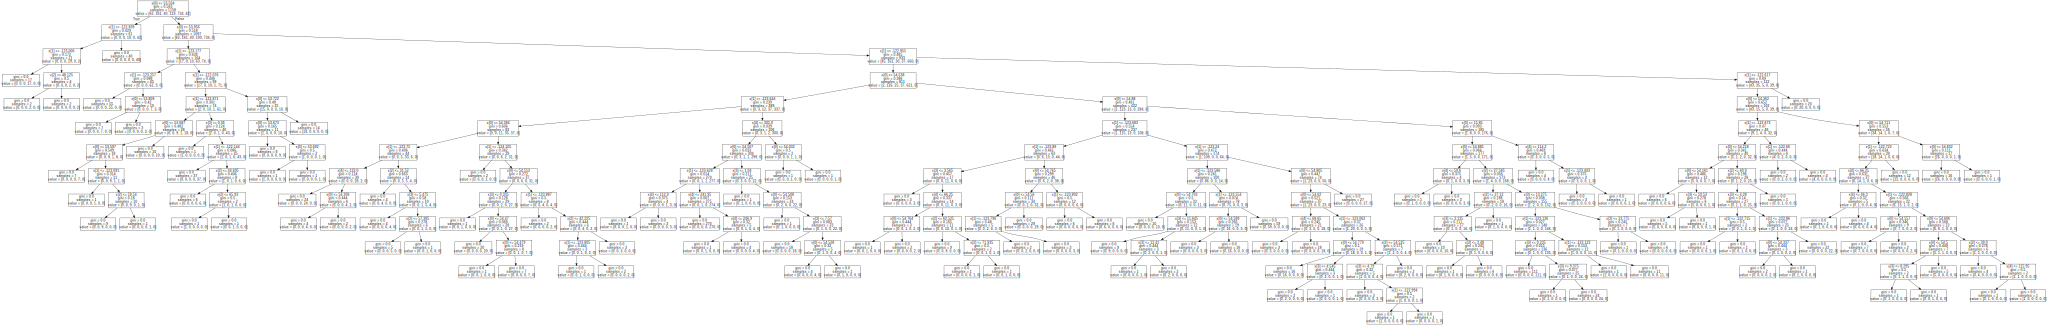

In [43]:
#visualizando a árvore de decisão
tree_data = tree.export_graphviz(model, out_file=None)
graph = graphviz.Source(tree_data, format='png')
graph

**2.2. Avaliação**

In [45]:
y_predicted = model.predict(X_test)

In [46]:
y_predicted[0:5]

array(['LTQCh', 'TrJTk', 'KTpg', 'TrJTk', 'TrJTk'], dtype=object)

In [47]:
y_predicted.shape

(571,)

In [51]:
y_test[0:5]

,STRAT
479,TrJTk
1082,TrJTk
403,KTpg
547,KTpg
491,TrJTk


In [49]:
y_test.shape

(571, 1)

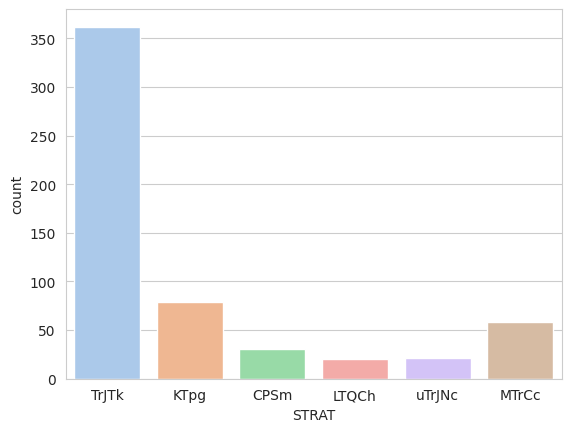

In [69]:
with sns.axes_style('whitegrid'):
  grafico2 = sns.countplot(data=y_test, x='STRAT', palette="pastel");

Temos uma previsão desbalanceada também, mas esse pode ser um conteúdo para um projeto futuro.

a. Matriz de Confusão

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [53]:
confusion_matrix = confusion_matrix(y_test, y_predicted)
print(confusion_matrix)

[[ 19   5   0   0   7   0]
 [  2  61   0   0  16   0]
 [  1   0  12   2   5   0]
 [  0   0   0  49   9   0]
 [  6  14  12   4 326   0]
 [  0   0   0   0   0  21]]


In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

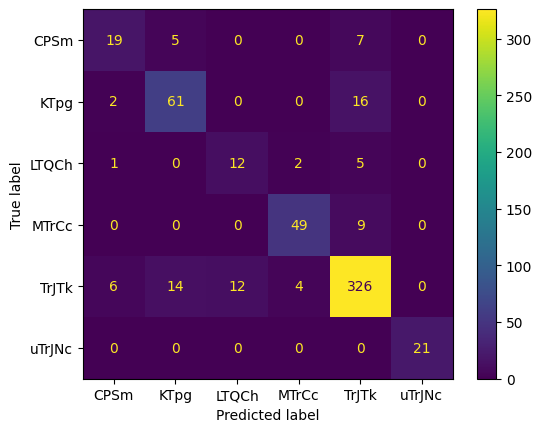

In [55]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_).plot()

plt.show()

A unidade geológica com todas as amostras reais sendo previstas como positivas (TP)  pelo modelo foi a uTrJNc, porém essa unidade tem poucas amostras (1,50% do total).<br>

Já a unidade TrJTk, com um número expressivo de amostras, foi a segunda com maior número de acertos, equivalente a 90,55% de acertos.<br>

A unidade MTrCc teve 84,48% de acertos, KTpg 77,21%, CPSm 61,29% e LTQCh 60%.<br>

A unidade LTQCh pode estar envolvida em mais erros por ser relacionada a rochas vulcânicas provenientes de eventos de derrames, isso faz com que tenha uma ampla distribuição espacial, o que implicaria em menor controle dos parâmetros de latitude e longitude quando comparadas às outras unidades estratigráficas. No mapa geológico, essa unidade é representada pela cor amarela, e ela é mais extensa que as outras unidades da bacia sedimentar.



b. Acurácia

In [59]:
total = confusion_matrix.sum()
print(total)

571


In [60]:
acertos = np.diag(confusion_matrix).sum()
print(acertos)

488


In [61]:
acuracia = acertos / total
print(acuracia)

0.8546409807355516


In [62]:
print(f"{round(100*acuracia,2)}%")

85.46%


A **acurácia**, de **85,46%**, pode ser considerada boa o suficiente para esse modelo, sendo uma boa indicação geral de como o modelo performou. Porém em um caso de desbalanceamento dos dados essa acurácia não seria muito representativa, como por exemplo no caso de unidades geológicas de interesse sendo classificadas como falso negativo.

A acurácia calculada no projeto de antes, quando os dados faltantes foram substituídos pela média antes de fazer o split entre treino e teste, era de 86,51%.

Pode-se dizer que não houve uma alteração significativa, uma vez que os dados faltantes estavam presentes apenas em um parâmetro (concentração de chumbo), em menos de 3% das amostras. Logo, os dados não enviesaram o modelo de maneira significativa nesse caso anterior, em que ocorreu data leakage.

c. Recall e Precisão

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_predicted, pos_label='positive', average='weighted')
recall = recall_score(y_test, y_predicted, pos_label='positive', average='weighted')
print(f"Recall: {recall:.3%}\nPrecisão: {precision:.3%}")

Recall: 85.639%
Precisão: 85.791%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


**Precisão** é um indicador que mostra dentre todas as classificações de classe positivo que o modelo fez (verdadeiros e falsos positivos), quantas estão corretas. Nesse caso foi de **86,67**%.

**Recall** ou **Revocação** mostra a quantidade, dentre todas as situações de classe positivo como valor esperado (VP e FN), quantas estão corretas. Nesse caso foi de **86.69%**.

Acredito que nesse caso de procura por uma unidade estratigráfica com um minério de interesse ocorre **a situação de Falsos Negativos serem consideradas mais prejudiciais que Falsos Positivos**. Por exemplo, o modelo deve encontrar de qualquer maneira todos os lugares possíveis de mineralizações, mesmo que classifique uma unidade estratigráfica não interessante como de interesse, do que perder um lugar que pode estar mineralizado e que foi classificado como falso negativo. Para isso, o modelo deve ter alto Recall.

 **2.3. Importância de Parâmetros**



Irei avaliar a importância dos parâmetros na classificação. As barras azuis correspondem às importâncias, enquanto que as variabilidades entre árvores são representadas pelas barras de erros.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

<ipython-input-39-747f6ab695c7>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.058 seconds


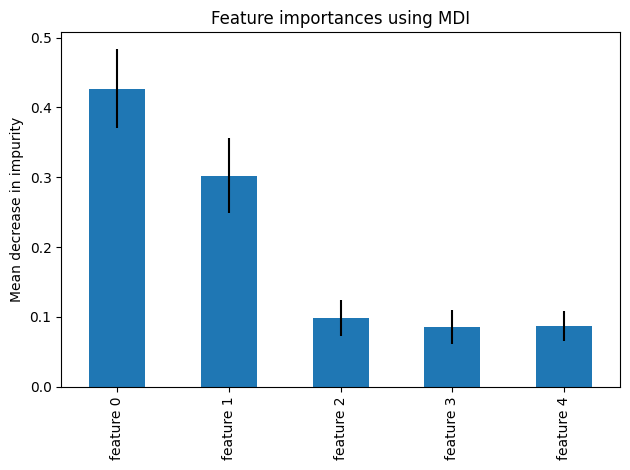

In [ ]:
#plotting impurity-based importance
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Sendo:<br>
feature 0 = LAT<br>
feature 1 = LONG<br>
feature 2 = Cu_ICP_PPM<br>
feature 3 = Pb_ICP_PPM<br>
feature 4 = Zn_ICP_PPM<br>

Os parâmetros 'latitude' e 'longitude' são os mais importantes para o modelo da árvore de decisão, em detrimento das concentrações de cobre, chumbo e zinco em ppm. Logo, latitude e longitude têm maior influência na tomada de decisão do modelo.



# **3. Conclusões**


* O modelo de Árvore de Decisão foi aplicado a um conjunto de dados de sedimentos de corrente, com os atributos escolhidos de latitude e longitude, concentrações de zn, cu e pb, a fim de predizer a unidade geológica correspondente. <br>
* Houve um viés de amostragem para a unidade TrTJk, com um número expressivo de amostras quando comparadas às outras unidades, porém isso é muito comum de ocorrer em dados geológicos. <br>
* A unidade LTQCh pode estar envolvida em mais erros de predição por estar relacionada a rochas vulcânicas provenientes de derrames, que estão mais distribuídas regionalmente em relação às outras rochas, o que a faz não estar tão bem caracterizada pelo modelo quanto às outras. <br>
* Pode-se dizer que esse modelo foi bem sucedido a predizer as unidades geológicas a partir dos parâmetros propostos, e a limpeza e o tratamento dos dados foi suficiente para que o modelo funcionasse bem também. A acurácia obtida foi de 85,46%.<br>
* Acredito que nesse caso de procura por uma unidade estratigráfica com uma mineralização de interesse ocorre a situação de Falsos Negativos serem consideradas mais prejudiciais que Falsos Positivos.</b>
* Os parâmetros de latitude e longitude são mais determinantes para a predição do modelo quando comparados aos teores de cobre, chumbo e zinco para o dataset escolhido. Isso poderia mudar caso o dataset mostrasse outliers em concentrações de elementos químicos, por exemplo, para unidades estratigráficas específicas ou de interesse.<br>
* Além disso, esse estudo é de grande importância econômica, podendo ajudar a predizer novos locais de mineralizações porfiríticas de Cu-Au escondidos por camadas de tilitos, e pode ser usado em conjunto com outros estudos geofísicos, como perfuração de poços e usos de dados magnéticos e gravimétricos.

# **Bibliografia**

British Columbia. [British Columbia Digital Geology](https://www2.gov.bc.ca/gov/content/industry/mineral-exploration-mining/british-columbia-geological-survey/geology/bcdigitalgeology)<br>

Brownlee, j. [Tour of Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)

Hayes, M.; Ferri, F. [Oil and Gas Opportunities in the Central British Columbia - Nechako Basin](https://www2.gov.bc.ca/assets/gov/farming-natural-resources-and-industry/natural-gas-oil/petroleum-geoscience/nechako_basin_interior.pdf)

Kushnir et al. (2012). [Rock Physical-Property Measurements for the Nechako Basin Oil and Gas Region, Central British Columbia](https://www.researchgate.net/publication/270279688_Rock_Physical-Property_Measurements_for_the_Nechako_Basin_Oil_and_Gas_Region_Central_British_Columbia_Parts_of_NTS_093B_C_E_F_G_K_L).

Palkovic, M. (2021).[Exploring Use Cases of Machine Learning in the Geosciences](https://towardsdatascience.com/exploring-use-cases-of-machine-learning-in-the-geosciences-b72ea7aafe2)

Scikit Learn. [Feature Importances with a Forest of Trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Turner et al. [Geotour Guide for Prince George, British Columbia](https://mineralsed.ca/site/assets/files/3451/princegeorgegeotourguide.pdf)

Williams, A. [Potential Copper-gold Deposits Found in Prince George Region](https://www.princegeorgecitizen.com/local-news/potential-copper-gold-deposits-found-in-prince-george-region-5012129)